# Look at along-swath PSD using xrft

In [14]:
import numpy as np
import numpy.testing as npt
import xarray as xr
import xrft
import numpy.fft as npft
import dask.array as dsar
import matplotlib.pyplot as plt
%matplotlib inline

# Add the path to the Tatsu's swot library
import sys
sys.path.append('../src/')
import tatsu_swot_utils as tatsu_swot
import tatsu_plotting_scripts as tatsu_swot_plot
import tatsu_data_loaders as tatsu_loader
import tatsu_download_swaths as tatsu_download

#turn off warnings
import warnings
warnings.filterwarnings("ignore")


In [15]:
def compute_power_spectra_xrft(swath,subset=False,lim0=1,lim1=519,assert_parseval=False):
    """
    Inputs
    ------
    swath: 
    clean_swath_nan:
    lim0: 
    lim1:
    

    Outputs
    ------
    freqs: 
    psd_orig:
    
    """
    # Nan out columns you don't want
    if subset:
        swath[:,:lim0] = np.nan
        swath[:,lim1:520-lim1] = np.nan
        swath[:,520-lim0:] = np.nan
        
    # Mask out NaNed columns (sides/middle os swath) 
    msk = np.isnan(swath.mean(axis=0))
    swath = swath[:,~msk]

    # I'm assuming the dataset shape here...
    swath = swath.T

    # Create output arrays
    freqs = np.zeros(swath.shape)
    psd_orig = np.zeros(swath.shape)
    # Fourier transform
    FT_orig = np.zeros(swath.shape)

    # Perform along-swath FFT
    for i in range(len(swath)):
        swath_i = swath[i,:]
        Nx = swath_i.size
        dx = .25
        da = xr.DataArray(swath_i,dims="x",coords={"x": dx * np.arange(0,swath_i.size)},)

        # Calculate FFT
        FT = xrft.dft(da, dim="x", true_phase=True, true_amplitude=True)
        # Calculate power spectrum
        ps = xrft.power_spectrum(da, dim="x")

        # Record
        freqs[i,:] = FT["freq_x"].values
        psd_orig[i,:] = ps.values
        
        if assert_parseval:
            ###############
            # Assert Parseval's using xrft.dft
            ###############
            print("Parseval's theorem directly from FFT:")
            print((np.abs(da) ** 2).sum() * dx)
            print((np.abs(FT) ** 2).sum() * FT["freq_x"].spacing)
            print()
                                   
            ###############
            # Assert Parseval's using xrft.power_spectrum with scaling='density'
            ###############
            print("Parseval's theorem from power spectrum:")        
            print(ps.sum())
            print((np.abs(da) ** 2).sum() * dx )
            print()
        
    return freqs, psd_orig


In [16]:
# Specify the path to the subsetted data
path = f"../../SWOT_L3/Unsmoothed"

# Define domain
# Rough California
sw_corner = [-150.0, 30.0]
ne_corner = [-115.0, 39.0]
lat_lims = [sw_corner[1],ne_corner[1]]

# Define mission phase (1-day repeat vs science) and 
# cycles we are interested in
# Use sph_calval_swath for the 1-day repeats
path_to_sph_file="../orbit_data/sph_calval_swath.zip"
# Cycles 474 - 578 are from the 1-day repeat 
cycles = [str(c_num).zfill(3) for c_num in range(474,500)]



pass_IDs_list = tatsu_download.find_swaths(sw_corner, ne_corner,
                                           path_to_sph_file=path_to_sph_file)
# Fast repeat California
pass_IDs_list = ["013","026"]

cycle_data = {}

# MAKE SURE TO CHANGE THE SAVE PATH
for cycle in cycles:
    cycle_data[cycle] = tatsu_loader.load_cycle(path,fields=["time","ssha","ssha_unedited","ssha_noiseless","sigma0"],
                                                cycle=cycle,pass_ids=pass_IDs_list,subset=True,lats=lat_lims
                                               )


Loading SWOT_L3_LR_SSH_Unsmoothed_474_013_20230329T081622_20230329T090619_v1.0.2.nc
Loading SWOT_L3_LR_SSH_Unsmoothed_474_026_20230329T191927_20230329T201032_v1.0.2.nc
Loading SWOT_L3_LR_SSH_Unsmoothed_475_026_20230330T191004_20230330T200109_v1.0.2.nc
Loading SWOT_L3_LR_SSH_Unsmoothed_476_013_20230331T083831_20230331T084734_v1.0.2.nc
Whoops can't open dataset
An error occured: 'list' object has no attribute 'assign_attrs'
Loading SWOT_L3_LR_SSH_Unsmoothed_477_026_20230401T185119_20230401T194225_v1.0.2.nc
Loading SWOT_L3_LR_SSH_Unsmoothed_478_013_20230402T073744_20230402T082850_v1.0.2.nc
Whoops can't open dataset
An error occured: [Errno -101] NetCDF: HDF error: '/scratch/projects/shaferlab/tatsu/SWOT_L3/Unsmoothed/cycle_478/SWOT_L3_LR_SSH_Unsmoothed_478_013_20230402T073744_20230402T082850_v1.0.2.nc'
Loading SWOT_L3_LR_SSH_Unsmoothed_478_026_20230402T184157_20230402T193303_v1.0.2.nc
Loading SWOT_L3_LR_SSH_Unsmoothed_479_013_20230403T072822_20230403T081927_v1.0.2.nc
Loading SWOT_L3_LR_SS

In [20]:
reload(tatsu_swot)

cycle_frqs = {}
cycle_psds = {}

cycle_frqs_test = {}
cycle_psds_test = {}

cycle_frqs_test_ne = {}
cycle_psds_test_ne = {}

cycle_frqs_ne = {}
cycle_psds_ne = {}

#cycle_frqs_sm = {}
#cycle_psds_sm = {}

# Save unsmoothed swath spectrums
for cycle in cycles:
    print(cycle)
    tmp_swaths = cycle_data[cycle]
    tmp_freqs, tmp_amps = [], []
    tmp_freqs_ne, tmp_amps_ne = [], []
    #tmp_freqs_sm, tmp_amps_sm = [], []
    for swath in tmp_swaths:
        # Pull unedited ssh and convert to cm
        swath_unsmoothed = swath.ssha_unedited.values[:,:]*100
        #swath_smoothed = swath.ssha_noiseless.values[:,:]*100
        # Mask out NaN columns
        #msk = np.isnan(swath_unsmoothed.mean(axis=0))
        #swath_unsmoothed = swath_unsmoothed[:,~msk]
        # Get the PSD in the along-swath direction
        freqs_ne, psd_ne = compute_power_spectra_xrft(swath_unsmoothed,subset=True,lim0=40,lim1=200)
        #freqs_sm, psd_sm = compute_power_spectra_xrft(swath_smoothed,subset=True,lim0=40,lim1=200)
    
        tmp_freqs_ne.append(freqs_ne)
        tmp_amps_ne.append(psd_ne)
        #tmp_freqs_sm.append(freqs_sm)
        #tmp_amps_sm.append(psd_sm)
    
    cycle_frqs_ne[cycle] = tmp_freqs_ne
    cycle_psds_ne[cycle] = tmp_amps_ne
    #cycle_frqs_sm[cycle] = tmp_freqs_sm
    #cycle_psds_sm[cycle] = tmp_amps_sm

    test_spectra = tatsu_swot.compute_power_spectra_xrft(cycle_data[cycle])
    test_spectra_ne = tatsu_swot.compute_power_spectra_xrft(cycle_data[cycle],subset=True,lim0=40,lim1=200)
    #test_spectra_smoothed = tatsu_swot.compute_power_spectra_xrft(cycle_data[cycle],subset=True,lim0=40,lim1=200)
    
    cycle_frqs_test[cycle] = test_spectra[0]
    cycle_psds_test[cycle] = test_spectra[1]
    #cycle_frqs_test_smoothed[cycle] = test_spectra_smoothed[0]
    #cycle_psds_test_smoothed[cycle] = test_spectra_smoothed[1]
    cycle_frqs_test_ne[cycle] = test_spectra_ne[0]
    cycle_psds_test_ne[cycle] = test_spectra_ne[1]
    


474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499


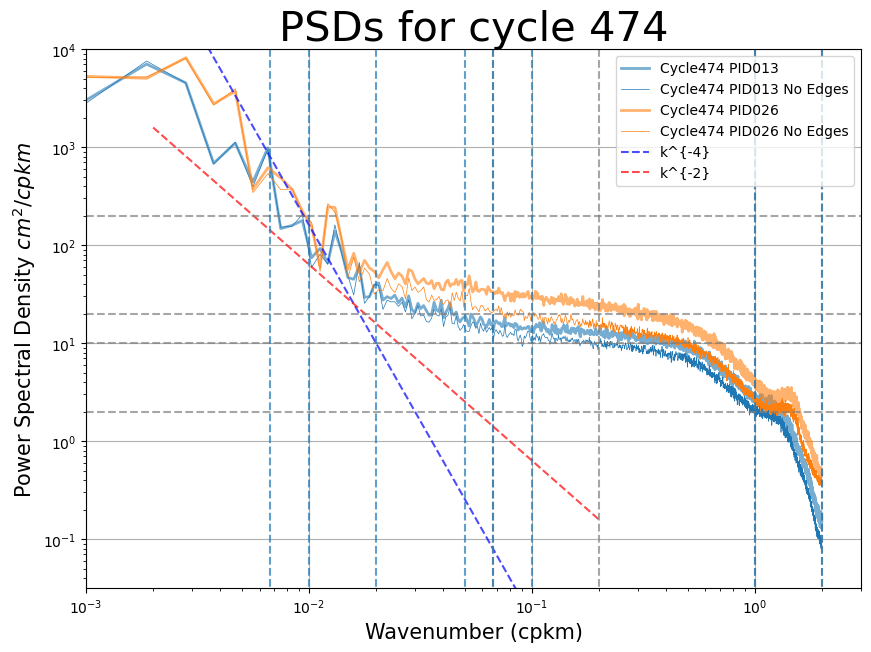

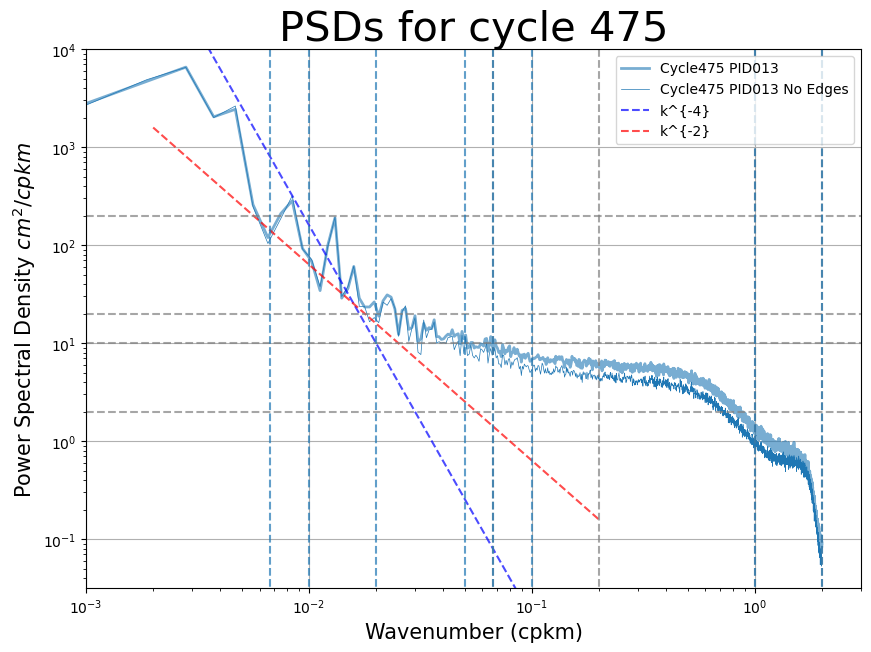

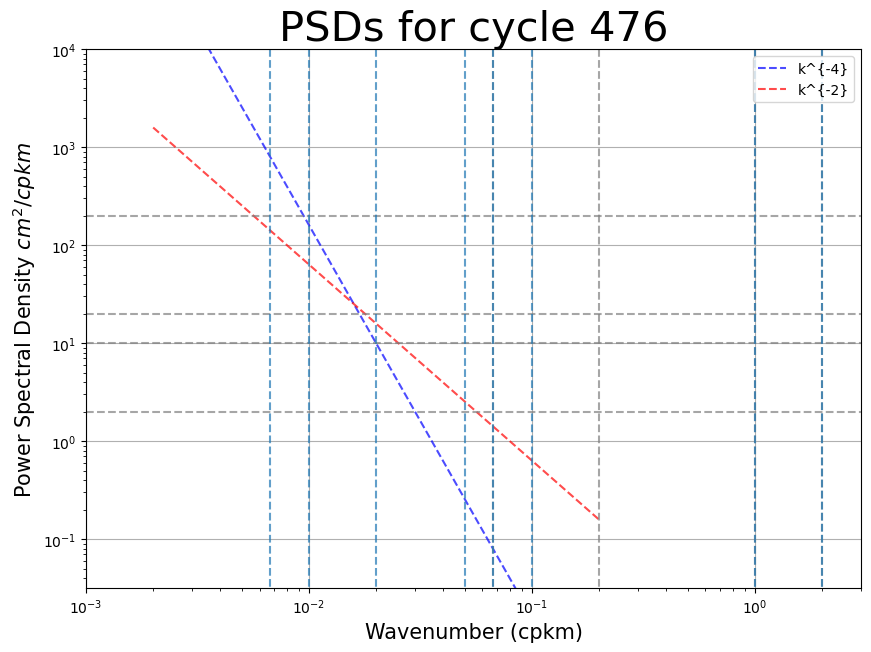

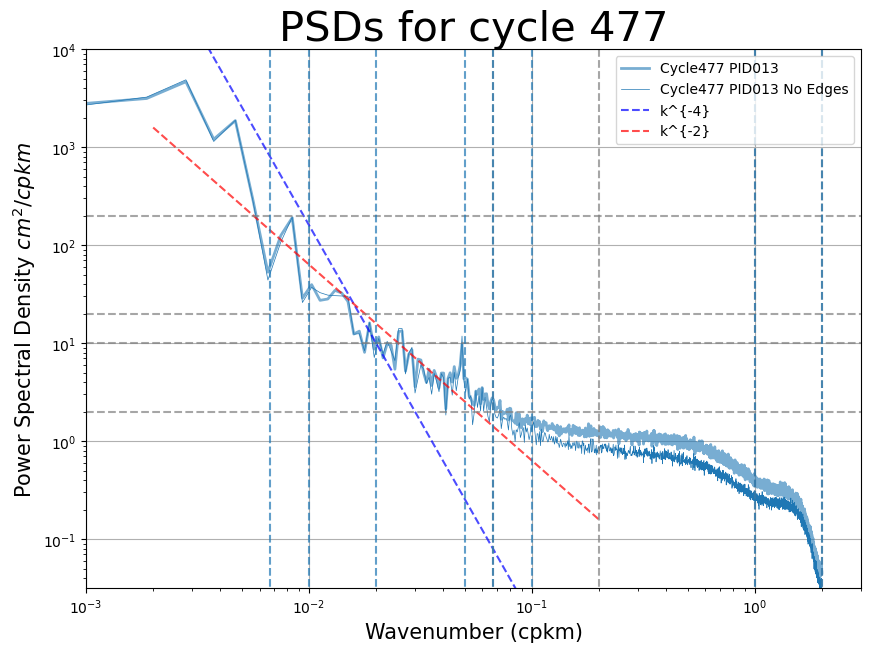

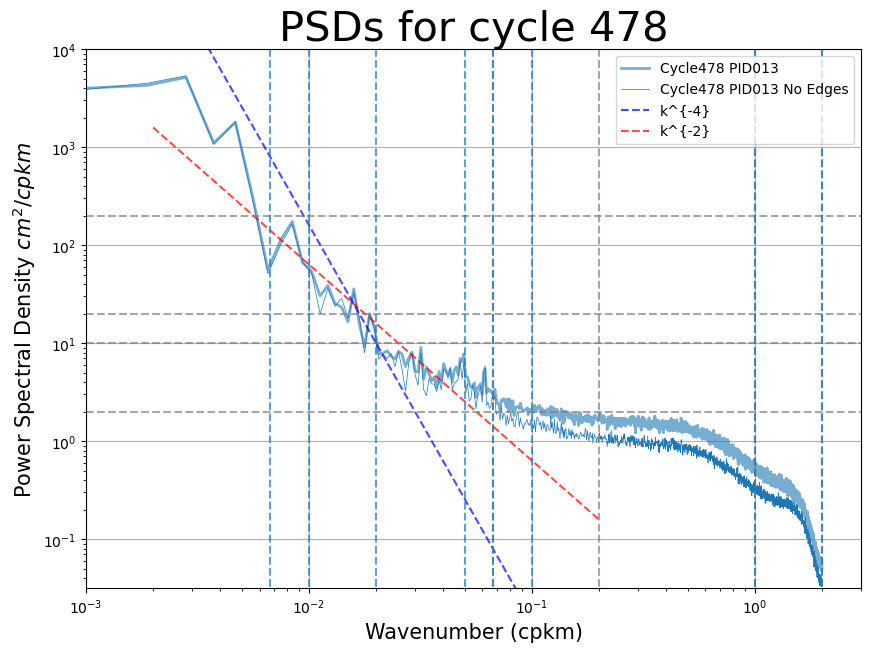

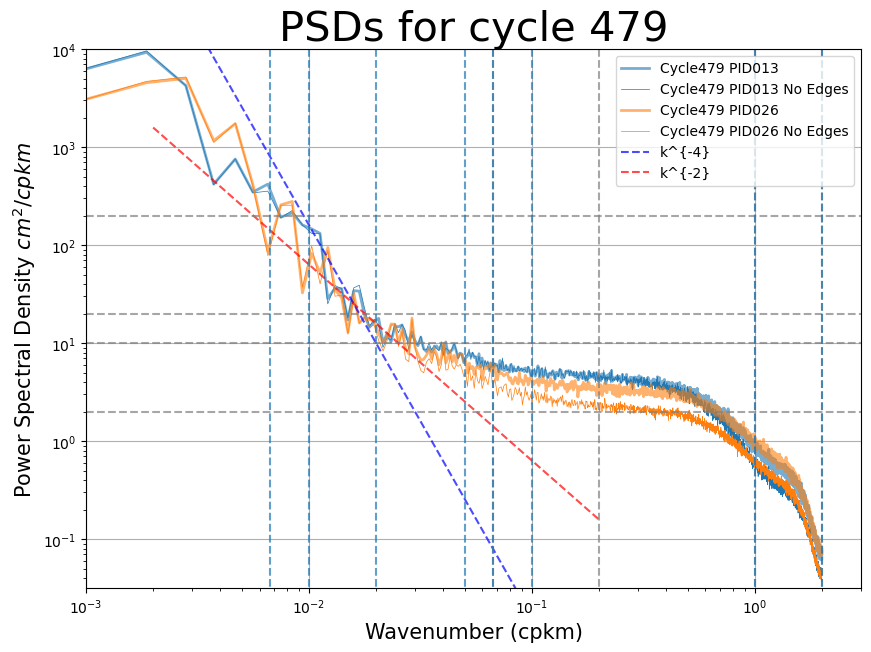

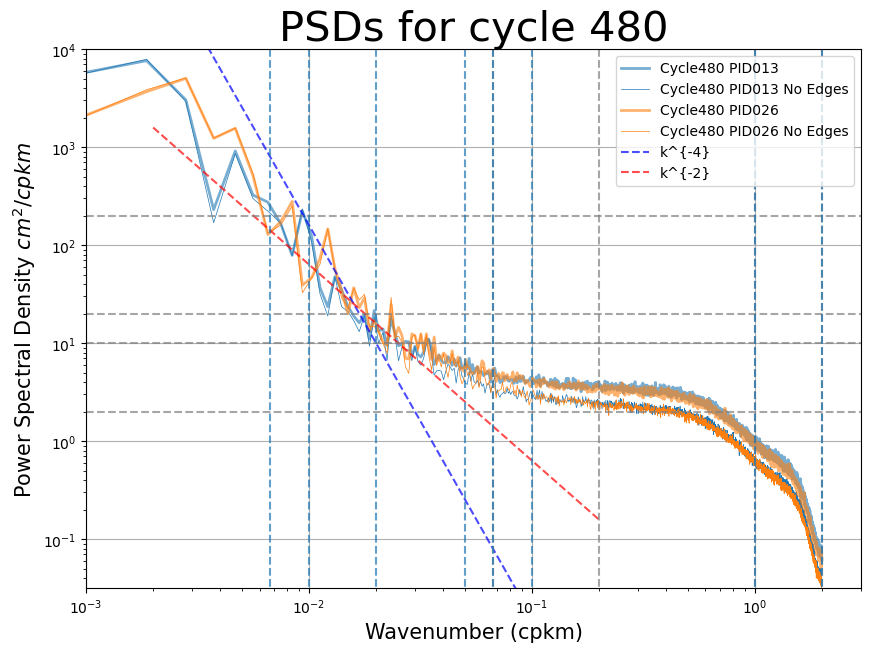

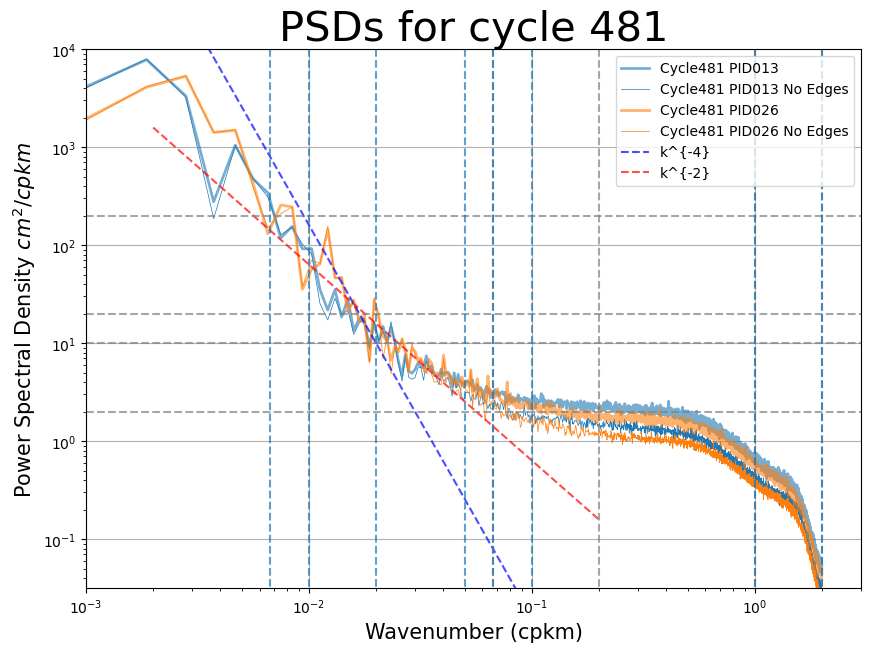

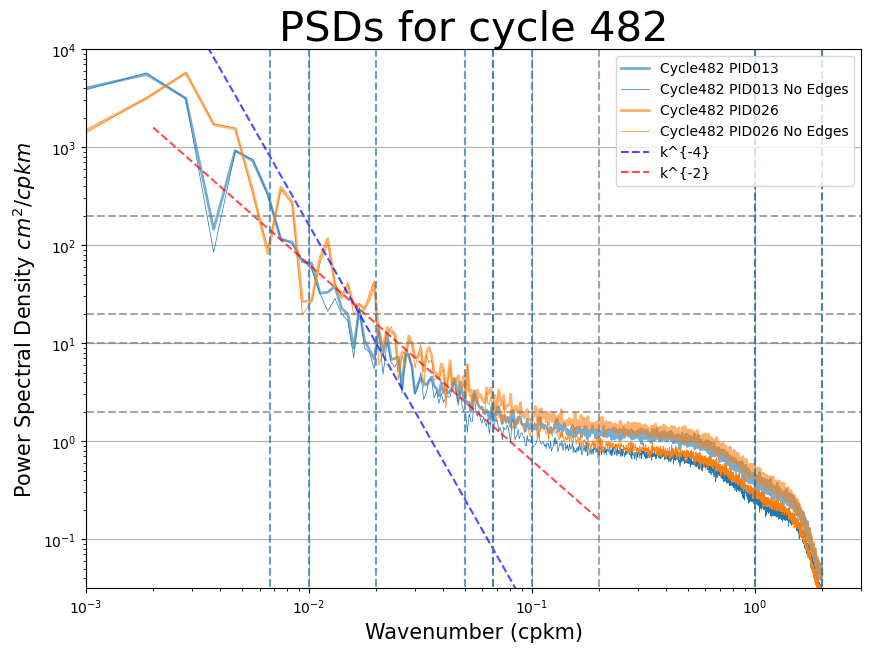

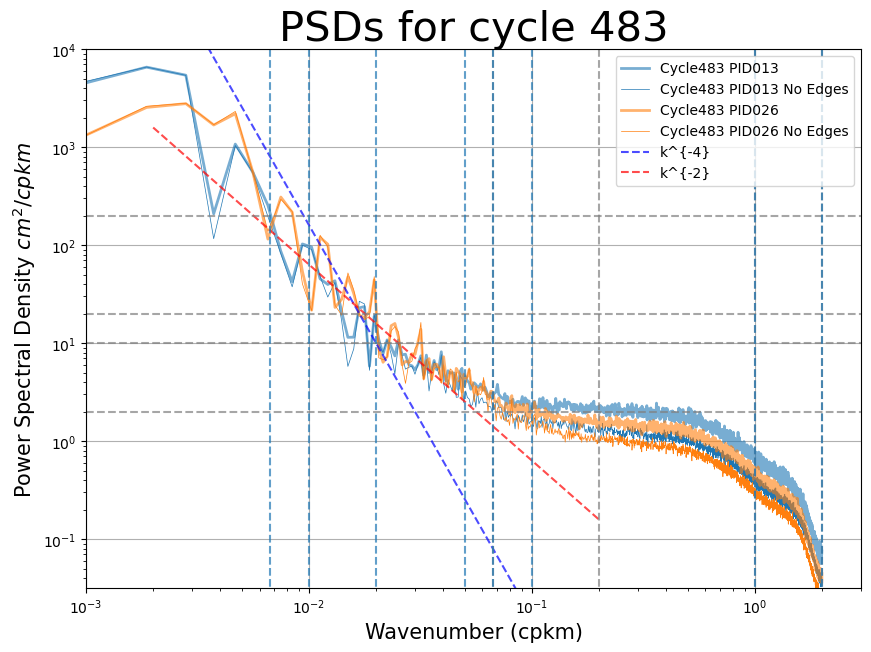

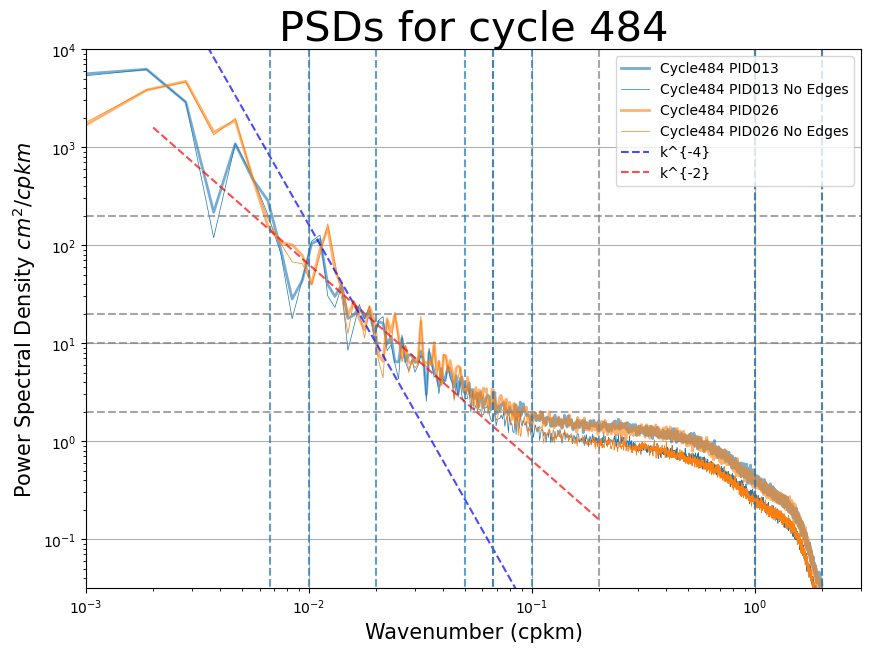

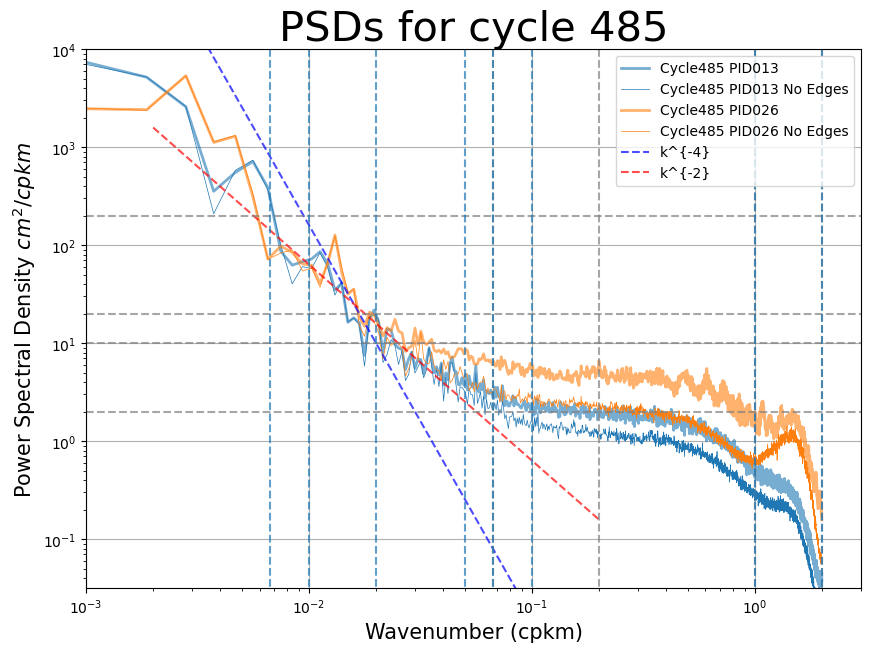

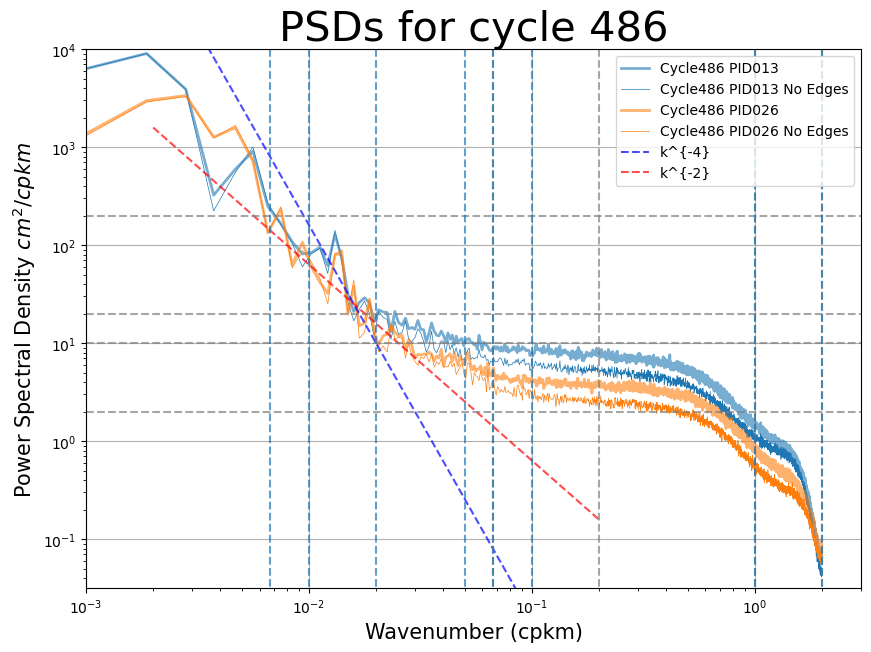

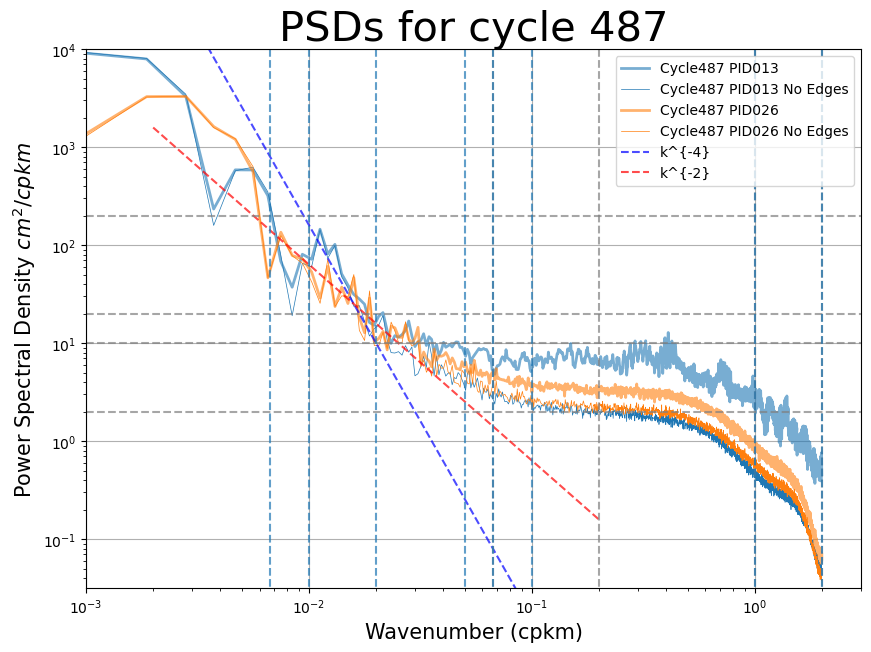

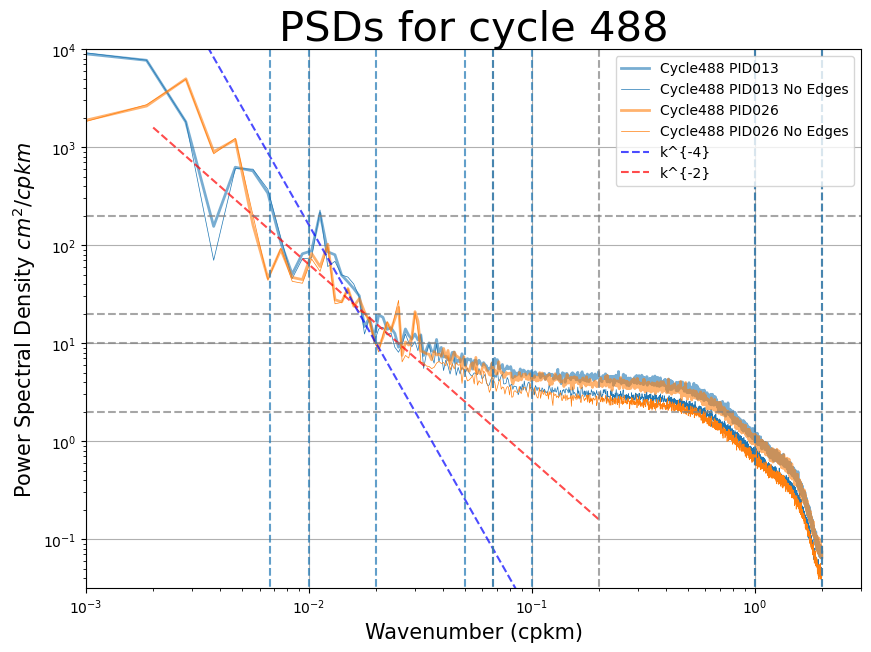

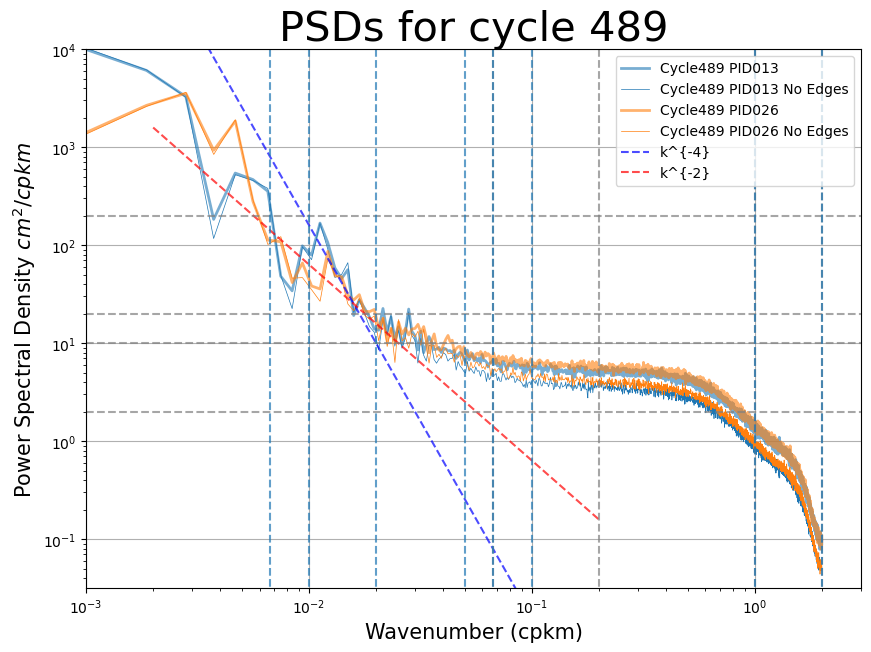

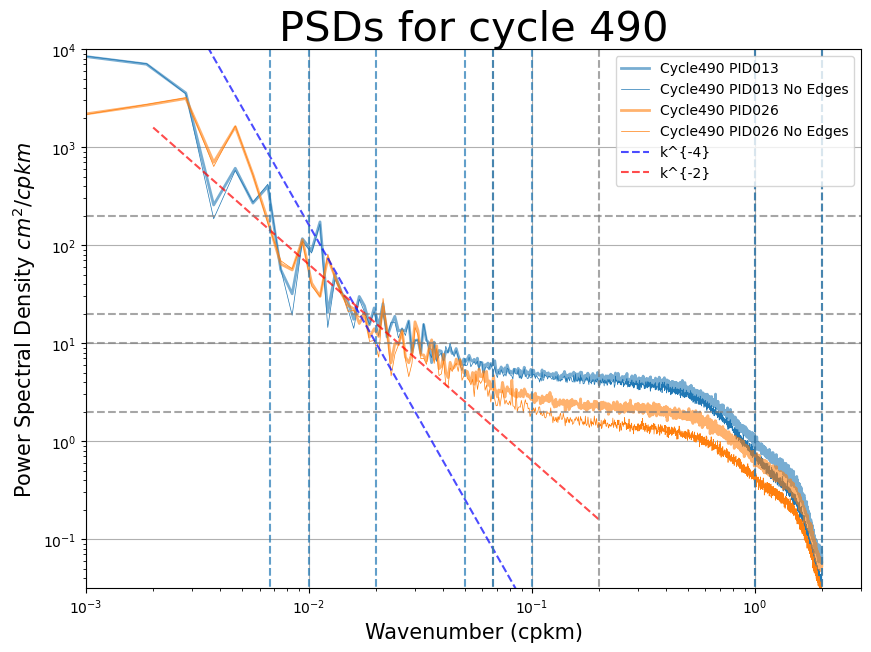

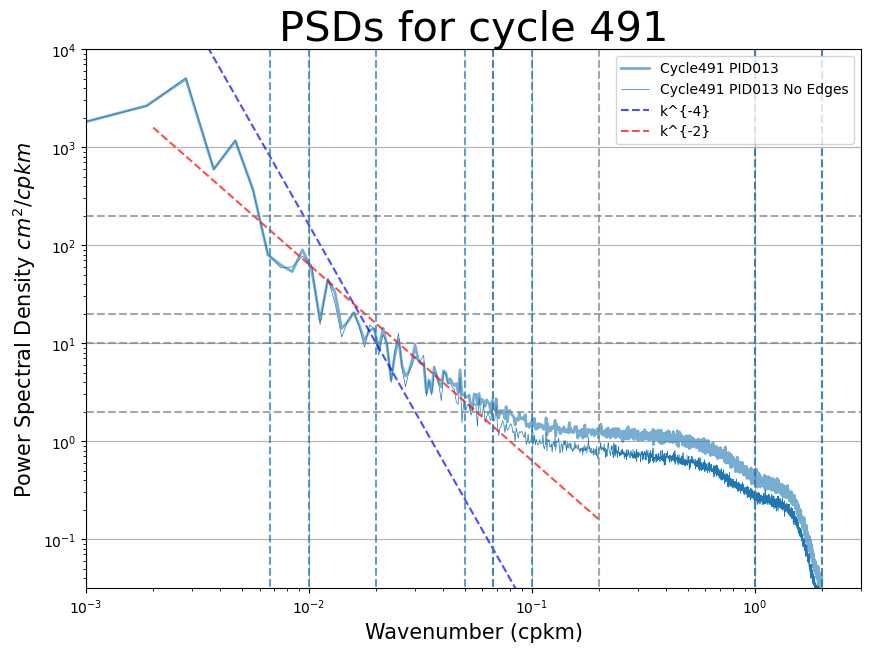

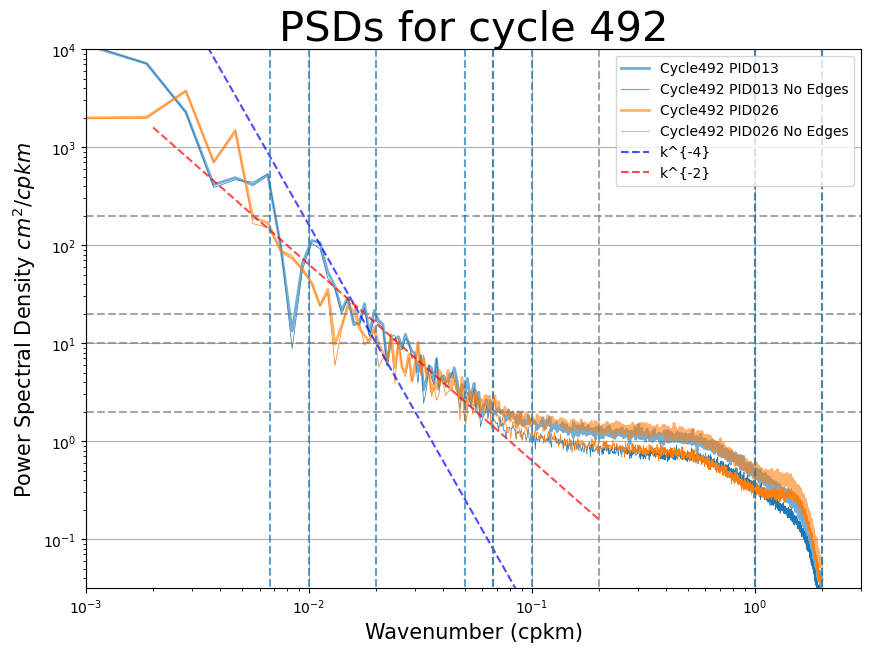

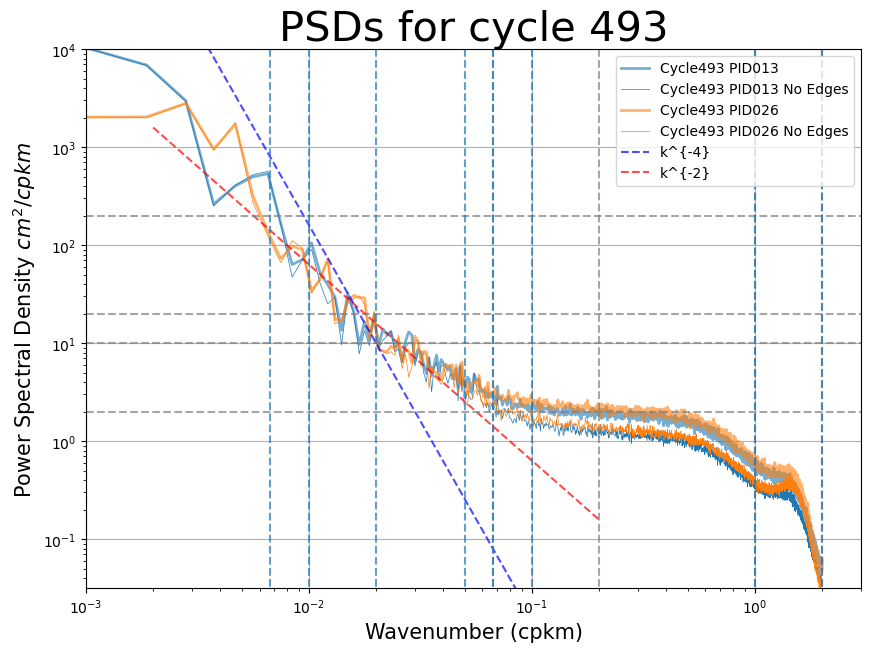

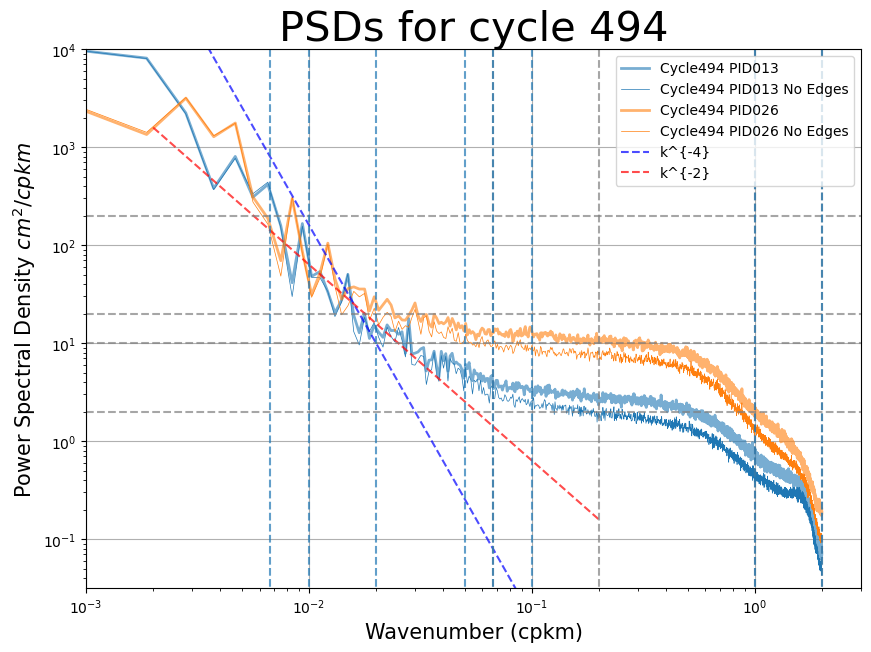

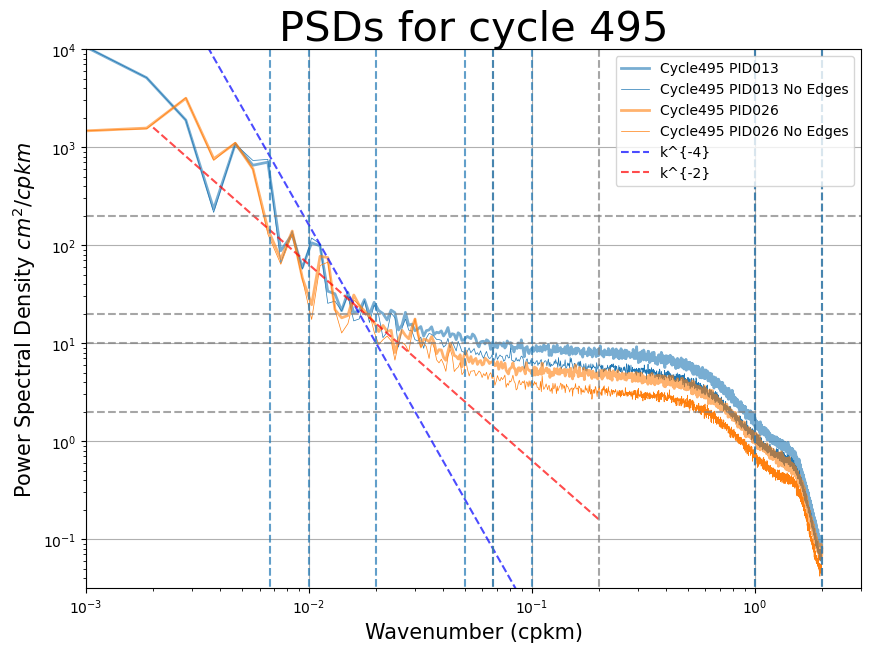

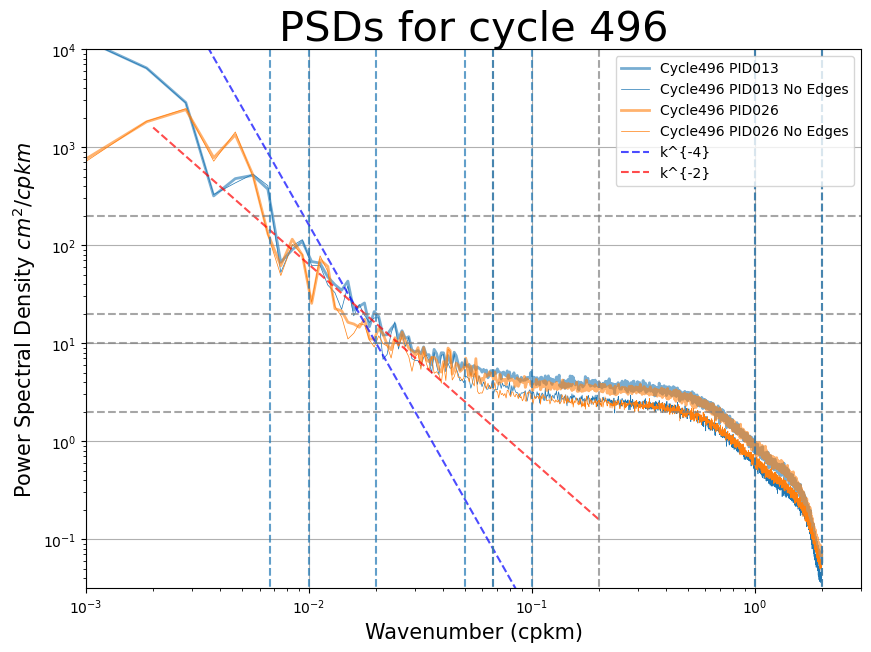

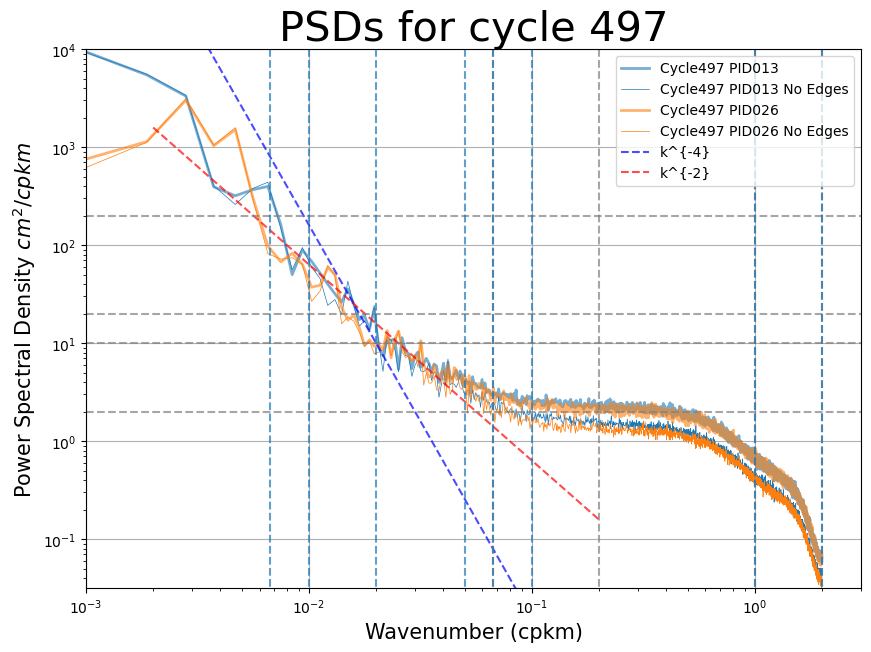

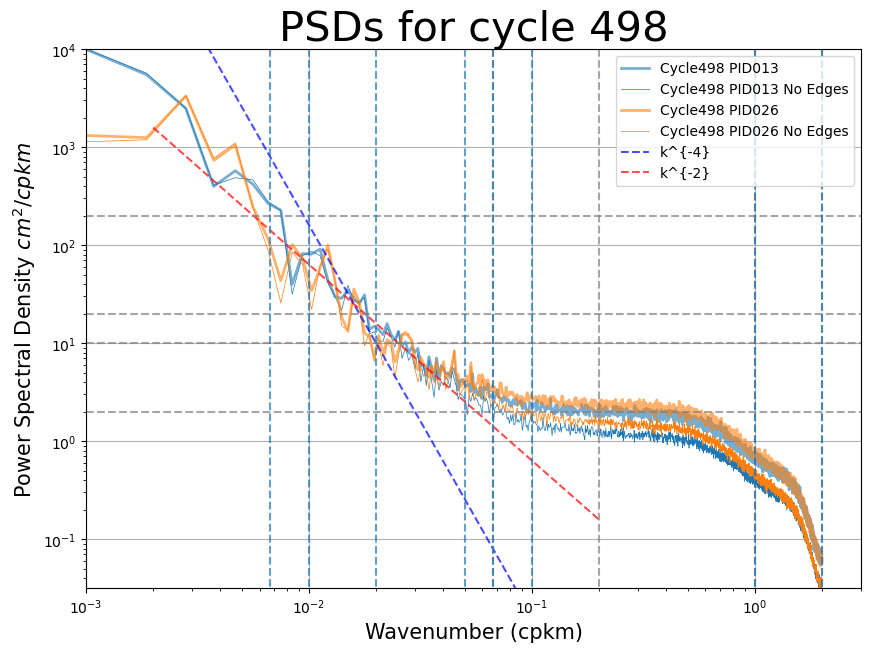

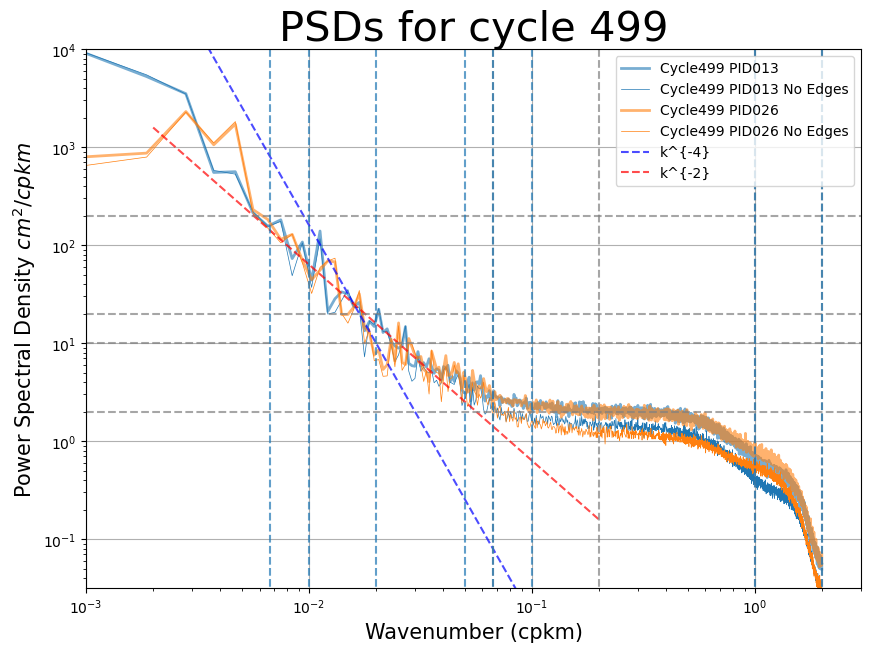

In [21]:
for cycle in cycles:
    
    fig, axs = plt.subplots(1,1,figsize=(10,7))
    
    for i, f in enumerate(cycle_frqs_test[cycle]):
        line, = axs.loglog(cycle_frqs_test[cycle][i].mean(axis=0),
                           cycle_psds_test[cycle][i].mean(axis=0),
                           label=f"Cycle{cycle} PID{pass_ids[i]}",alpha=0.6,linewidth=2)
        
        axs.loglog(cycle_frqs_test_ne[cycle][i].mean(axis=0),
                   cycle_psds_test_ne[cycle][i].mean(axis=0),
                   label=f"Cycle{cycle} PID{pass_ids[i]} No Edges",
                   alpha=1,color=line.get_color(),linewidth=0.5)

    x = np.linspace(0.01, 1, 100)
    axs.loglog(x*.15, (x**-4)/10**2.5, color='blue',label="k^{-4}",linestyle="dashed",alpha=0.7)
    axs.loglog(x*.2, (x**-2)/10**.8, color='red',label="k^{-2}",linestyle="dashed",alpha=0.7)
    
    axs.hlines([2, 10,20,200],10**-3,10,color="grey",linestyle="--",alpha=0.7)
    axs.vlines([1/15,1/5,1, 2],0,10**5,color="grey",linestyle="--",alpha=0.7)
    
    axs.set_title(f"PSDs for cycle {cycle}",fontsize=30)
    axs.set_xlabel('Wavenumber (cpkm)',fontsize=15)
    axs.set_ylabel('Power Spectral Density $cm^{2}/cpkm$',fontsize=15)

    axs.vlines([1/150,1/100,1/50,1/20,1/15,1/10,1/1,1/.5],0,10**5,linestyle="--",alpha=0.7)
    axs.legend()
    axs.set_ylim(10**-1.5,10**4)
    axs.set_xlim(10**-3,3)
    axs.grid()
    
    plt.show()
    plt.close()